# Binary U-net

## Import data

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [4]:
testSetId = '1Gmb5aFWuR8kmfDjulgN2h90FutCxQVmF'
trainingSetId = '19vro2YKFiURqqmFGYYIx0ZDkirn4F9mk'
originalId = '16ibmmBvAYsw9ztlO6KpccQDAzvulEADX'
segmentedId = '1KAurcmqTNxD4ivXD2UNcfDYrfgi4BooZ'
binaryId = '1A1sT2-QNEYFvvjcRNSpwavSkTYRKbouY'
binaryMatId = '1AqMAZ7UujizxgijD1LvFs4qenqSZZ8fo'
segmentedMatId = '1a2BFzPPBYt703pStH3VAF8RzvlmiOoDa'
adamId = '1fsO5bdK36Lw-19MuQIhNB-LkhUaWi77L'
sgdId = '1qNjFzotb-nfisUJ20CpjQzvABeHEnBzq'
nadamId = '1zc68ggl3QRM9PoMG-_i1dKjHn9DQTVW-'
adamaxId = '1Pk0JsFrRTyYwB--RVwQZcB8i-keyMd8w'
adagradId = '1yjV8kjmZlHrM8AlTiy9eujdd0Iyc4NEq'
adadeltaId = '1Gm0TBfsJMldO2kE7WwEkJ-2tWNxUzDEL'

In [5]:
import io
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

def importFromDrive(filename, nameId):
  request = drive_service.files().get_media(fileId=nameId)
  variable = io.FileIO(filename, 'wb')
  downloader = MediaIoBaseDownload(variable, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = downloader.next_chunk()

  variable.seek(0)

In [6]:
importFromDrive('trainSet.mat', trainingSetId)
importFromDrive('testSet.mat', testSetId)
importFromDrive('original.zip', originalId)
importFromDrive('segmented_images.zip', segmentedId)
importFromDrive('segmented_mat.zip', segmentedMatId)
importFromDrive('binary_images.zip', binaryId)
importFromDrive('binary_mat.zip', binaryMatId)
importFromDrive('adam.zip', adamId)
importFromDrive('sgd.zip', sgdId)
importFromDrive('nadam.zip', nadamId)
importFromDrive('adamax.zip', adamaxId)
importFromDrive('adagrad.zip', adagradId)
importFromDrive('adadelta.zip', adadeltaId)

In [ ]:
#!rm -r data/original data/segmented_images data/binary_images data/segmented_mat data/binary_mat
!unzip original.zip -d data/
#!unzip segmented_images.zip -d data/
!unzip binary_images.zip -d data/
#!unzip segmented_mat.zip -d data/
!unzip binary_mat.zip -d data
!mkdir results_binary
!mkdir results_segmentation
!unzip adam.zip -d results_binary
!unzip adadelta.zip -d results_binary
!unzip adagrad.zip -d results_binary
!unzip adamax.zip -d results_binary
!unzip nadam.zip -d results_binary
!unzip sgd.zip -d results_binary

## Read data

In [8]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 100

Using TensorFlow backend.


In [9]:
import scipy.io
train_ids = scipy.io.loadmat('trainSet.mat', squeeze_me=True)
test_ids = scipy.io.loadmat('testSet.mat', squeeze_me=True)
train_ids = train_ids['TrainingSet']
test_ids = test_ids['TestSet']

In [19]:
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = 'data/original/'
        img = imread(path + id_ + '.jpg')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        path_mask = 'data/binary_images/'
        #path_mask = 'data/binary_mat/'
        mask_ = imread(path_mask + id_ + '.png', flatten=True)
        #mask_ = scipy.io.loadmat(path_mask + id_ + '.mat')
        #mask_ = mask_['annotated'][:,:,0]
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = mask_
        
        #for mask_file in next(os.walk(path + '/masks/'))[2]:
        #    mask_ = imread(path + '/masks/' + mask_file)
        #    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        #    mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [20]:
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1))
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy") and os.path.isfile("test_mask.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        Y_test = np.load("test_mask.npy")
        return X_test,sizes_test, Y_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = 'data/original/'
        img = imread(path + id_ + '.jpg')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        path_mask = 'data/binary_images/'
        #path_mask = 'data/binary_mat/'
        mask_ = imread(path_mask + id_ + '.png', flatten=True)
        #mask_ = scipy.io.loadmat(path_mask + id_ + '.mat')
        #mask_ = mask_['annotated'][:,:,0]
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = mask_
        
        #for mask_file in next(os.walk(path + '/masks/'))[2]:
        #    mask_ = imread(path + '/masks/' + mask_file)
        #    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        #    mask = np.maximum(mask, mask_)
        Y_test[n] = mask
        
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    np.save("test_mask", Y_test)
    return X_test,sizes_test,Y_test

### Data augmentation

In [21]:
def image_PCA(A):
  A_rs = A.reshape(-1,3)
  A_c = A_rs - A_rs.mean(axis=0)
  A_cov = np.cov(A_c, rowvar=False)
  eig_vals, eig_vecs = np.linalg.eigh(A_cov)
  sort_perm = eig_vals[::-1].argsort()
  eig_vals[::-1].sort()     
  eig_vecs = eig_vecs[:, sort_perm]
  m1 = np.column_stack((eig_vecs))
  m2 = np.zeros((3,1))
  for i in range(eig_vals.shape[0]):
     m2[i][0] = np.random.normal(0, 0.1)*eig_vals[i]
  add_v = np.matrix(m1)*np.matrix(m2)
  A_scale = A/255.0
  # Adding the value to create a augmented image
  for i in range(A_scale.shape[0]):
    for j in range(A_scale.shape[1]):
      for k in range(A_scale.shape[2]):
        # just avoided the negative values and also make sure data stays between 0 and 1
        A_scale[i,j,k] = min(abs(float(A_scale[i,j,k]) + float(add_v[k])),1)
  return A_scale

def augment_data(X, Y):
  X_PCA = np.zeros((X.shape[0], X.shape[1], X.shape[2], X.shape[3]))
  print("Applying PCA to images...")
  b = Progbar(X.shape[0])
  for i in range(X.shape[0]):
    A = image_PCA(X[i])
    X_PCA[i] = A
    b.update(i)
  X = np.concatenate((X,X_PCA), axis=0)
  Y = np.concatenate((Y,Y), axis=0)
  
  print("\nFlipping images...")
  X1 = np.flip(X, 0)
  #X2 = np.flip(X, 1)
  #X3 = np.flip(X1, 1)
  X = np.concatenate((X,X1), axis=0)
  Y1 = np.flip(Y,0)
  #Y2 = np.flip(Y, 1)
  #Y3 = np.flip(Y1, 1)
  Y = np.concatenate((Y,Y1), axis=0)
  
  return X,Y

## U-net architecture

In [22]:
def get_unet(optimizer, loss, IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
    return model

In [27]:
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

## Read and augment data

In [24]:
# get train_data
train_img,train_mask = read_train_data()

# get test_data
test_img,test_img_sizes, test_mask = read_test_data()

Getting and resizing train images and masks ... 
649/650 [============================>.] - ETA: 0s
Getting and resizing test images ... 
179/360 [=============>................] - ETA: 2:06359/360 [============================>.] - ETA: 0s

In [25]:
train_img, train_mask = augment_data(train_img, train_mask)

Applying PCA to images...
649/650 [============================>.] - ETA: 1s
Flipping images...


In [0]:
train_img.shape

(2600, 256, 256, 3)

## Training

In [0]:
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
def saveToDrive(optimizer):
  file_metadata = {
    'name': optimizer + '.zip',
    'mimeType': 'application/zip',
    'parents' : ['10BdJFewgcur0FvhwPNdvZEmDYVsY13IW']
  }
  media = MediaFileUpload('results_binary/' + optimizer + '.zip', 
                          mimetype='application/zip',
                          resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                         media_body=media,
                                         fields='id').execute()
  print('File ID: {}'.format(created.get('id')))

### Adam

In [26]:
# get u_net model
optimizer = 'adam'
loss = 'binary_crossentropy'
u_net = get_unet(optimizer, loss)

In [0]:
print("\nTraining...")
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, validation_data=(test_img, test_mask), callbacks=[model_checkpoint])
#Y = u_net.predict(test_img, verbose=1)
#!mkdir results_binary
#!mkdir results_binary/adam
#for j in range(0,Y.shape[0]):
#   scipy.misc.imsave('results_binary/' + optimizer + '/' + test_ids[j] + '.png', np.squeeze(Y[j,:,:], axis=2))
# !zip -r results_binary/{optimizer}.zip results_binary/{optimizer}
# saveToDrive(optimizer)

In [17]:
saveToDrive(optimizer)

File ID: 1fsO5bdK36Lw-19MuQIhNB-LkhUaWi77L


In [0]:
def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(loss, linewidth=3, label='train')
  plt.plot(val_loss, linewidth=3, label='valid')
  plt.grid()
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.ylim(1e-2, 1)
  plt.yscale('log') 
  plt.show()

### Stochastic gradient descent

In [19]:
optimizer = 'sgd'
loss = 'binary_crossentropy'
u_net = get_unet(optimizer, loss)
print("\nTraining...")
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
history2 = u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, validation_data=(test_img, test_mask), callbacks=[model_checkpoint])
Y = u_net.predict(test_img, verbose=1)
!mkdir results_binary/{optimizer}
for j in range(0,Y.shape[0]):
  scipy.misc.imsave('results_binary/' + optimizer + '/' + test_ids[j] + '.png', np.squeeze(Y[j,:,:], axis=2))
!zip -r results_binary/{optimizer}.zip results_binary/{optimizer}
saveToDrive(optimizer)


Training...
Train on 2600 samples, validate on 360 samples
Epoch 1/100
2600/2600 [==============================] - 63s 24ms/step - loss: 0.4668 - acc: 0.8569 - val_loss: 0.3858 - val_acc: 0.8581

Epoch 00001: loss improved from inf to 0.46684, saving model to unet.hdf5
Epoch 2/100
2600/2600 [==============================] - 62s 24ms/step - loss: 0.3940 - acc: 0.8570 - val_loss: 0.3323 - val_acc: 0.8581

Epoch 00002: loss improved from 0.46684 to 0.39404, saving model to unet.hdf5
Epoch 3/100
 384/2600 [===>..........................] - ETA: 50s - loss: 0.3782 - acc: 0.85672600/2600 [==============================] - 61s 24ms/step - loss: 0.3603 - acc: 0.8570 - val_loss: 0.2606 - val_acc: 0.8582

Epoch 00003: loss improved from 0.39404 to 0.36028, saving model to unet.hdf5
Epoch 4/100
2600/2600 [==============================] - 61s 24ms/step - loss: 0.3262 - acc: 0.8777 - val_loss: 0.2061 - val_acc: 0.9349

Epoch 00004: loss improved from 0.36028 to 0.32622, saving model to unet.hdf

1616/2600 [=================>............] - ETA: 22s - loss: 0.2170 - acc: 0.91052600/2600 [==============================] - 61s 24ms/step - loss: 0.2154 - acc: 0.9113 - val_loss: 0.2220 - val_acc: 0.9437

Epoch 00033: loss did not improve from 0.21503
Epoch 34/100
2600/2600 [==============================] - 61s 24ms/step - loss: 0.2141 - acc: 0.9114 - val_loss: 0.2470 - val_acc: 0.9396

Epoch 00034: loss improved from 0.21503 to 0.21411, saving model to unet.hdf5
Epoch 35/100
1664/2600 [==================>...........] - ETA: 21s - loss: 0.2124 - acc: 0.91172600/2600 [==============================] - 61s 24ms/step - loss: 0.2124 - acc: 0.9117 - val_loss: 0.2371 - val_acc: 0.9409

Epoch 00035: loss improved from 0.21411 to 0.21240, saving model to unet.hdf5
Epoch 36/100
2600/2600 [==============================] - 62s 24ms/step - loss: 0.2096 - acc: 0.9127 - val_loss: 0.1600 - val_acc: 0.9544

Epoch 00036: loss improved from 0.21240 to 0.20962, saving model to unet.hdf5
Epoch 37/100

1376/2600 [==============>...............] - ETA: 27s - loss: 0.1903 - acc: 0.91692600/2600 [==============================] - 61s 24ms/step - loss: 0.1952 - acc: 0.9146 - val_loss: 0.1924 - val_acc: 0.9481

Epoch 00067: loss improved from 0.19566 to 0.19519, saving model to unet.hdf5
Epoch 68/100
2600/2600 [==============================] - 61s 24ms/step - loss: 0.1957 - acc: 0.9144 - val_loss: 0.1611 - val_acc: 0.9539

Epoch 00068: loss did not improve from 0.19519
Epoch 69/100
1456/2600 [===============>..............] - ETA: 25s - loss: 0.1954 - acc: 0.91442600/2600 [==============================] - 61s 24ms/step - loss: 0.1948 - acc: 0.9146 - val_loss: 0.1631 - val_acc: 0.9530

Epoch 00069: loss improved from 0.19519 to 0.19477, saving model to unet.hdf5
Epoch 70/100
2600/2600 [==============================] - 61s 24ms/step - loss: 0.1946 - acc: 0.9147 - val_loss: 0.1706 - val_acc: 0.9515

Epoch 00070: loss improved from 0.19477 to 0.19464, saving model to unet.hdf5
Epoch 71/100

  adding: results_binary/sgd/20151204_113839.png (deflated 0%)
  adding: results_binary/sgd/20151221_124149.png (deflated 1%)
  adding: results_binary/sgd/20151127_130448.png (stored 0%)
  adding: results_binary/sgd/20151204_123204.png (deflated 1%)
  adding: results_binary/sgd/20151221_121231.png (stored 0%)
  adding: results_binary/sgd/20151211_135141.png (deflated 1%)
  adding: results_binary/sgd/20151221_113425.png (stored 0%)
  adding: results_binary/sgd/20151204_122510.png (stored 0%)
  adding: results_binary/sgd/20151204_132542.png (deflated 5%)
  adding: results_binary/sgd/20151204_123539.png (stored 0%)
  adding: results_binary/sgd/20151221_133902.png (stored 0%)
  adding: results_binary/sgd/20151127_135241.png (stored 0%)
  adding: results_binary/sgd/20151211_133050.png (stored 0%)
  adding: results_binary/sgd/20151204_115551.png (deflated 0%)
  adding: results_binary/sgd/20151203_125246.png (stored 0%)
  adding: results_binary/sgd/20151221_123559.png (stored 0%)
  adding: re

### Adagrad

In [20]:
optimizer = 'adagrad'
loss = 'binary_crossentropy'
u_net = get_unet(optimizer, loss)
print("\nTraining...")
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
history3 = u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, validation_data=(test_img, test_mask), callbacks=[model_checkpoint])
Y = u_net.predict(test_img, verbose=1)
!mkdir results_binary/{optimizer}
for j in range(0,Y.shape[0]):
  scipy.misc.imsave('results_binary/' + optimizer + '/' + test_ids[j] + '.png', np.squeeze(Y[j,:,:], axis=2))
!zip -r results_binary/{optimizer}.zip results_binary/{optimizer}
saveToDrive(optimizer)


Training...
Train on 2600 samples, validate on 360 samples
Epoch 1/100
2600/2600 [==============================] - 64s 25ms/step - loss: 2.2825 - acc: 0.8569 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00001: loss improved from inf to 2.28254, saving model to unet.hdf5
Epoch 2/100
2600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00002: loss did not improve from 2.28254
Epoch 3/100
 400/2600 [===>..........................] - ETA: 50s - loss: 2.3001 - acc: 0.85662600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00003: loss did not improve from 2.28254
Epoch 4/100
2600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00004: loss did not improve from 2.28254
Epoch 5/100
1568/2600 [=================>............] - ETA: 23s - loss: 2.3120 - acc: 0.8

1808/2600 [===================>..........] - ETA: 18s - loss: 2.2931 - acc: 0.85712600/2600 [==============================] - 62s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00037: loss did not improve from 2.28254
Epoch 38/100
2600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00038: loss did not improve from 2.28254
Epoch 39/100
1808/2600 [===================>..........] - ETA: 18s - loss: 2.2867 - acc: 0.85752600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00039: loss did not improve from 2.28254
Epoch 40/100
2600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00040: loss did not improve from 2.28254
Epoch 41/100
1808/2600 [===================>..........] - ETA: 18s - loss: 2.2945 - acc: 0.85702600/2600 

1808/2600 [===================>..........] - ETA: 18s - loss: 2.3142 - acc: 0.85582600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00073: loss did not improve from 2.28254
Epoch 74/100
2600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00074: loss did not improve from 2.28254
Epoch 75/100
1808/2600 [===================>..........] - ETA: 18s - loss: 2.2907 - acc: 0.85722600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00075: loss did not improve from 2.28254
Epoch 76/100
2600/2600 [==============================] - 63s 24ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00076: loss did not improve from 2.28254
Epoch 77/100
1808/2600 [===================>..........] - ETA: 18s - loss: 2.3089 - acc: 0.85612600/2600 

File ID: 1yjV8kjmZlHrM8AlTiy9eujdd0Iyc4NEq


### Adadelta

In [21]:
optimizer = 'adadelta'
loss = 'binary_crossentropy'
u_net = get_unet(optimizer, loss)
print("\nTraining...")
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
history4 = u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, validation_data=(test_img, test_mask), callbacks=[model_checkpoint])
Y = u_net.predict(test_img, verbose=1)
!mkdir results_binary/{optimizer}
for j in range(0,Y.shape[0]):
  scipy.misc.imsave('results_binary/' + optimizer + '/' + test_ids[j] + '.png', np.squeeze(Y[j,:,:], axis=2))
!zip -r results_binary/{optimizer}.zip results_binary/{optimizer}
saveToDrive(optimizer)


Training...
Train on 2600 samples, validate on 360 samples
Epoch 1/100
2600/2600 [==============================] - 67s 26ms/step - loss: 0.3381 - acc: 0.8832 - val_loss: 0.1522 - val_acc: 0.9527

Epoch 00001: loss improved from inf to 0.33805, saving model to unet.hdf5
Epoch 2/100
2600/2600 [==============================] - 65s 25ms/step - loss: 0.2669 - acc: 0.9050 - val_loss: 0.1635 - val_acc: 0.9545

Epoch 00002: loss improved from 0.33805 to 0.26694, saving model to unet.hdf5
Epoch 3/100
 384/2600 [===>..........................] - ETA: 53s - loss: 0.2576 - acc: 0.90512600/2600 [==============================] - 65s 25ms/step - loss: 0.2405 - acc: 0.9087 - val_loss: 0.1505 - val_acc: 0.9463

Epoch 00003: loss improved from 0.26694 to 0.24051, saving model to unet.hdf5
Epoch 4/100
2600/2600 [==============================] - 65s 25ms/step - loss: 0.2114 - acc: 0.9129 - val_loss: 0.0766 - val_acc: 0.9754

Epoch 00004: loss improved from 0.24051 to 0.21137, saving model to unet.hdf

1616/2600 [=================>............] - ETA: 23s - loss: 0.1676 - acc: 0.92012600/2600 [==============================] - 65s 25ms/step - loss: 0.1627 - acc: 0.9229 - val_loss: 0.0519 - val_acc: 0.9823

Epoch 00035: loss did not improve from 0.16258
Epoch 36/100
2600/2600 [==============================] - 65s 25ms/step - loss: 0.1624 - acc: 0.9230 - val_loss: 0.0397 - val_acc: 0.9873

Epoch 00036: loss improved from 0.16258 to 0.16237, saving model to unet.hdf5
Epoch 37/100
1664/2600 [==================>...........] - ETA: 22s - loss: 0.1598 - acc: 0.92462600/2600 [==============================] - 65s 25ms/step - loss: 0.1616 - acc: 0.9233 - val_loss: 0.0411 - val_acc: 0.9870

Epoch 00037: loss improved from 0.16237 to 0.16158, saving model to unet.hdf5
Epoch 38/100
2600/2600 [==============================] - 65s 25ms/step - loss: 0.1615 - acc: 0.9234 - val_loss: 0.0423 - val_acc: 0.9868

Epoch 00038: loss improved from 0.16158 to 0.16148, saving model to unet.hdf5
Epoch 39/100

1520/2600 [================>.............] - ETA: 26s - loss: 0.1584 - acc: 0.92332600/2600 [==============================] - 65s 25ms/step - loss: 0.1580 - acc: 0.9241 - val_loss: 0.0412 - val_acc: 0.9879

Epoch 00069: loss did not improve from 0.15752
Epoch 70/100
2600/2600 [==============================] - 65s 25ms/step - loss: 0.1574 - acc: 0.9243 - val_loss: 0.0396 - val_acc: 0.9884

Epoch 00070: loss improved from 0.15752 to 0.15743, saving model to unet.hdf5
Epoch 71/100
1648/2600 [==================>...........] - ETA: 23s - loss: 0.1586 - acc: 0.92372600/2600 [==============================] - 65s 25ms/step - loss: 0.1573 - acc: 0.9243 - val_loss: 0.0416 - val_acc: 0.9884

Epoch 00071: loss improved from 0.15743 to 0.15728, saving model to unet.hdf5
Epoch 72/100
2600/2600 [==============================] - 65s 25ms/step - loss: 0.1590 - acc: 0.9239 - val_loss: 0.0377 - val_acc: 0.9884

Epoch 00072: loss did not improve from 0.15728
Epoch 73/100
1488/2600 [================>..

  adding: results_binary/adadelta/20151221_132315.png (deflated 1%)
  adding: results_binary/adadelta/20151221_125935.png (deflated 2%)
  adding: results_binary/adadelta/20151211_125829.png (deflated 0%)
  adding: results_binary/adadelta/20151204_113839.png (deflated 1%)
  adding: results_binary/adadelta/20151221_124149.png (deflated 1%)
  adding: results_binary/adadelta/20151127_130448.png (deflated 0%)
  adding: results_binary/adadelta/20151204_123204.png (deflated 2%)
  adding: results_binary/adadelta/20151221_121231.png (deflated 1%)
  adding: results_binary/adadelta/20151211_135141.png (deflated 2%)
  adding: results_binary/adadelta/20151221_113425.png (deflated 1%)
  adding: results_binary/adadelta/20151204_122510.png (deflated 1%)
  adding: results_binary/adadelta/20151204_132542.png (deflated 2%)
  adding: results_binary/adadelta/20151204_123539.png (deflated 1%)
  adding: results_binary/adadelta/20151221_133902.png (deflated 1%)
  adding: results_binary/adadelta/20151127_13524

### Adamax

In [22]:
optimizer = 'adamax'
loss = 'binary_crossentropy'
u_net = get_unet(optimizer, loss)
print("\nTraining...")
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
history5 = u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, validation_data=(test_img, test_mask), callbacks=[model_checkpoint])
Y = u_net.predict(test_img, verbose=1)
!mkdir results_binary/{optimizer}
for j in range(0,Y.shape[0]):
  scipy.misc.imsave('results_binary/' + optimizer + '/' + test_ids[j] + '.png', np.squeeze(Y[j,:,:], axis=2))
!zip -r results_binary/{optimizer}.zip results_binary/{optimizer}
saveToDrive(optimizer)


Training...
Train on 2600 samples, validate on 360 samples
Epoch 1/100
2600/2600 [==============================] - 66s 25ms/step - loss: 0.2824 - acc: 0.8820 - val_loss: 0.1117 - val_acc: 0.9648

Epoch 00001: loss improved from inf to 0.28241, saving model to unet.hdf5
Epoch 2/100
2600/2600 [==============================] - 63s 24ms/step - loss: 0.1927 - acc: 0.9152 - val_loss: 0.0788 - val_acc: 0.9747

Epoch 00002: loss improved from 0.28241 to 0.19274, saving model to unet.hdf5
Epoch 3/100
 384/2600 [===>..........................] - ETA: 51s - loss: 0.1893 - acc: 0.91622600/2600 [==============================] - 63s 24ms/step - loss: 0.1846 - acc: 0.9169 - val_loss: 0.0644 - val_acc: 0.9779

Epoch 00003: loss improved from 0.19274 to 0.18461, saving model to unet.hdf5
Epoch 4/100
2600/2600 [==============================] - 64s 24ms/step - loss: 0.1793 - acc: 0.9181 - val_loss: 0.0651 - val_acc: 0.9784

Epoch 00004: loss improved from 0.18461 to 0.17926, saving model to unet.hdf

1408/2600 [===============>..............] - ETA: 27s - loss: 0.1524 - acc: 0.92682600/2600 [==============================] - 63s 24ms/step - loss: 0.1571 - acc: 0.9245 - val_loss: 0.0399 - val_acc: 0.9877

Epoch 00035: loss did not improve from 0.15706
Epoch 36/100
2600/2600 [==============================] - 63s 24ms/step - loss: 0.1565 - acc: 0.9246 - val_loss: 0.0396 - val_acc: 0.9881

Epoch 00036: loss improved from 0.15706 to 0.15655, saving model to unet.hdf5
Epoch 37/100
1616/2600 [=================>............] - ETA: 22s - loss: 0.1590 - acc: 0.92362600/2600 [==============================] - 63s 24ms/step - loss: 0.1568 - acc: 0.9245 - val_loss: 0.0431 - val_acc: 0.9875

Epoch 00037: loss did not improve from 0.15655
Epoch 38/100
2600/2600 [==============================] - 63s 24ms/step - loss: 0.1577 - acc: 0.9242 - val_loss: 0.0378 - val_acc: 0.9882

Epoch 00038: loss did not improve from 0.15655
Epoch 39/100
1776/2600 [===================>..........] - ETA: 19s - loss:

1424/2600 [===============>..............] - ETA: 27s - loss: 0.1547 - acc: 0.92512600/2600 [==============================] - 63s 24ms/step - loss: 0.1538 - acc: 0.9255 - val_loss: 0.0478 - val_acc: 0.9890

Epoch 00069: loss improved from 0.15388 to 0.15378, saving model to unet.hdf5
Epoch 70/100
2600/2600 [==============================] - 63s 24ms/step - loss: 0.1537 - acc: 0.9255 - val_loss: 0.0489 - val_acc: 0.9886

Epoch 00070: loss improved from 0.15378 to 0.15373, saving model to unet.hdf5
Epoch 71/100
1376/2600 [==============>...............] - ETA: 28s - loss: 0.1501 - acc: 0.92732600/2600 [==============================] - 63s 24ms/step - loss: 0.1538 - acc: 0.9255 - val_loss: 0.0458 - val_acc: 0.9889

Epoch 00071: loss did not improve from 0.15373
Epoch 72/100
2600/2600 [==============================] - 63s 24ms/step - loss: 0.1536 - acc: 0.9255 - val_loss: 0.0478 - val_acc: 0.9888

Epoch 00072: loss improved from 0.15373 to 0.15362, saving model to unet.hdf5
Epoch 73/100

  adding: results_binary/adamax/20151221_122828.png (deflated 2%)
  adding: results_binary/adamax/20151204_115038.png (deflated 2%)
  adding: results_binary/adamax/20151211_115730.png (deflated 1%)
  adding: results_binary/adamax/20151127_131106.png (deflated 1%)
  adding: results_binary/adamax/20151204_120254.png (deflated 2%)
  adding: results_binary/adamax/20151127_131209.png (deflated 2%)
  adding: results_binary/adamax/20151204_121736.png (deflated 1%)
  adding: results_binary/adamax/20151204_131212.png (deflated 0%)
  adding: results_binary/adamax/20151221_115219.png (deflated 1%)
  adding: results_binary/adamax/20151211_135815.png (deflated 1%)
  adding: results_binary/adamax/20151221_134018.png (deflated 0%)
  adding: results_binary/adamax/20151211_120606.png (deflated 0%)
  adding: results_binary/adamax/20151127_130844.png (deflated 1%)
  adding: results_binary/adamax/20151211_125634.png (deflated 0%)
  adding: results_binary/adamax/20151127_125829.png (deflated 1%)
  adding: 

### Nadam

In [23]:
optimizer = 'nadam'
loss = 'binary_crossentropy'
u_net = get_unet(optimizer, loss)
print("\nTraining...")
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
history6 = u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, validation_data=(test_img, test_mask), callbacks=[model_checkpoint])
Y = u_net.predict(test_img, verbose=1)
!mkdir results_binary/{optimizer}
for j in range(0,Y.shape[0]):
  scipy.misc.imsave('results_binary/' + optimizer + '/' + test_ids[j] + '.png', np.squeeze(Y[j,:,:], axis=2))
!zip -r results_binary/{optimizer}.zip results_binary/{optimizer}
saveToDrive(optimizer)


Training...
Train on 2600 samples, validate on 360 samples
Epoch 1/100
2600/2600 [==============================] - 69s 26ms/step - loss: 0.3347 - acc: 0.8897 - val_loss: 0.1726 - val_acc: 0.9486

Epoch 00001: loss improved from inf to 0.33471, saving model to unet.hdf5
Epoch 2/100
2600/2600 [==============================] - 66s 25ms/step - loss: 2.2238 - acc: 0.8583 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00002: loss did not improve from 0.33471
Epoch 3/100
 400/2600 [===>..........................] - ETA: 53s - loss: 2.2976 - acc: 0.85682600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00003: loss did not improve from 0.33471
Epoch 4/100
2600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00004: loss did not improve from 0.33471
Epoch 5/100
1568/2600 [=================>............] - ETA: 25s - loss: 2.2786 - acc: 0.8

1808/2600 [===================>..........] - ETA: 19s - loss: 2.3102 - acc: 0.85602600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00037: loss did not improve from 0.33471
Epoch 38/100
2600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00038: loss did not improve from 0.33471
Epoch 39/100
1808/2600 [===================>..........] - ETA: 19s - loss: 2.2968 - acc: 0.85682600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00039: loss did not improve from 0.33471
Epoch 40/100
2600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00040: loss did not improve from 0.33471
Epoch 41/100
1808/2600 [===================>..........] - ETA: 19s - loss: 2.2975 - acc: 0.85682600/2600 

1808/2600 [===================>..........] - ETA: 19s - loss: 2.3053 - acc: 0.85632600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00073: loss did not improve from 0.33471
Epoch 74/100
2600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00074: loss did not improve from 0.33471
Epoch 75/100
1808/2600 [===================>..........] - ETA: 19s - loss: 2.2927 - acc: 0.85712600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00075: loss did not improve from 0.33471
Epoch 76/100
2600/2600 [==============================] - 66s 25ms/step - loss: 2.2951 - acc: 0.8570 - val_loss: 2.2769 - val_acc: 0.8581

Epoch 00076: loss did not improve from 0.33471
Epoch 77/100
1808/2600 [===================>..........] - ETA: 19s - loss: 2.2880 - acc: 0.85742600/2600 

File ID: 1zc68ggl3QRM9PoMG-_i1dKjHn9DQTVW-


### Plot of loss curve

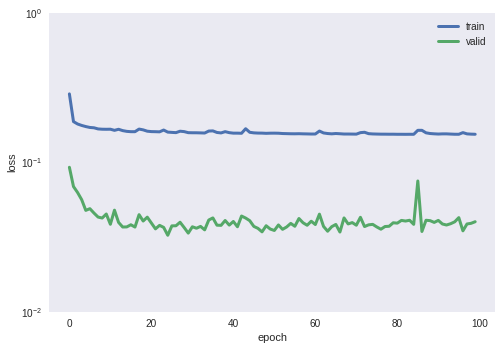

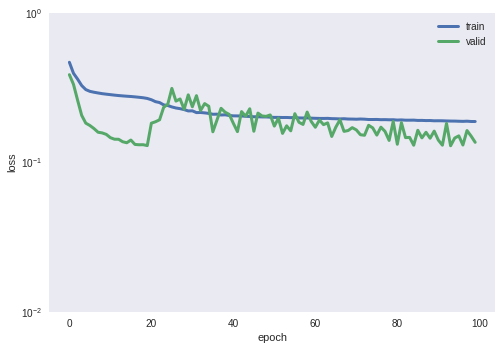

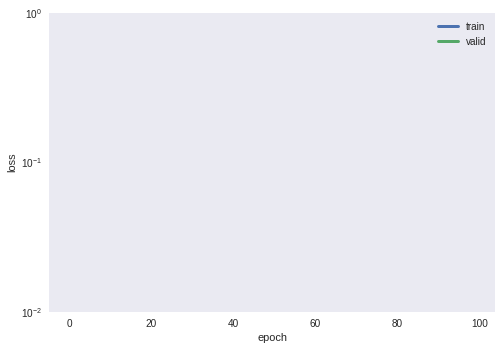

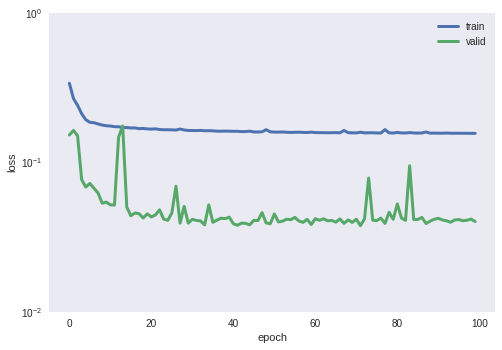

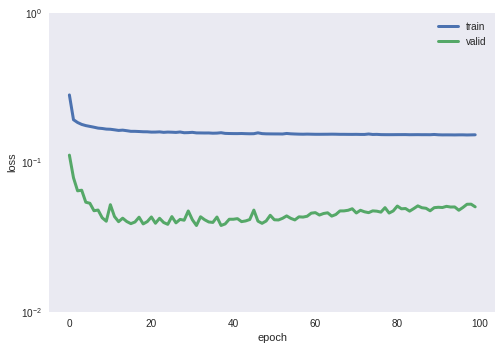

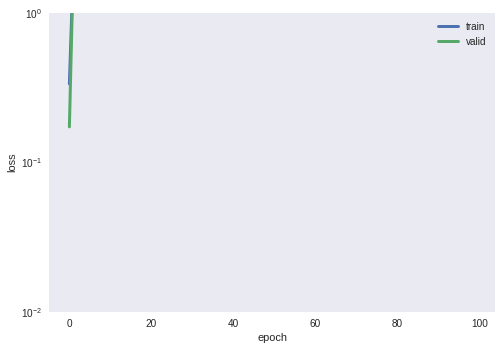

In [24]:
plot_loss(history)
plot_loss(history2)
plot_loss(history3)
plot_loss(history4)
plot_loss(history5)
plot_loss(history6)

## Results statistics

### IOU

In [11]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 1.8MB/s 


In [12]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import img_as_bool
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def IOU(truth, segm):
  if truth.shape != segm.shape:
    print("Groud truth and segmented image should have the same size.")
    return
  truth = truth/np.max(truth)
  segm = segm/np.max(segm)
  intersection = np.logical_and(truth, segm)
  inter_count = np.sum(intersection)
  union = np.logical_or(truth, segm)
  union_count = np.sum(union)
  iou = inter_count/union_count
  return iou
  
def mean_IOU(truth, segm):
  if truth.shape != segm.shape:
    print("Groud truth and segmented images should have the same size.")
    return
  nb_img = truth.shape[0]
  sum_iou = 0
  for i in range(nb_img):
    sum_iou = sum_iou + IOU(truth[i], segm[i])
  mean_iou = sum_iou/nb_img
  return mean_iou

In [3]:
optimizers = ['adam', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam']
def accuracy_IOU(optimizer):
  N = len(test_ids)
  n = 256
  m = 256
  truth = np.zeros((N,n,m))
  segm = np.zeros((N,n,m))
  for i in tqdm(range(N)):
    img_id = test_ids[i]
    original_binary = 'data/binary_images/' + img_id + '.png'
    unet_binary = 'results_binary/results_binary/' + optimizer + '/' + img_id + '.png'
    truth_id = imread(original_binary, flatten=True)
    truth_id = resize(truth_id, (256, 256), mode='constant', preserve_range=False)
    segm_id = imread(unet_binary)
    truth[i] = truth_id
    segm[i] = segm_id
  mean_iou = mean_IOU(truth, segm)
  return mean_iou
  print("Mean IOU for Adam optimizer: {}".format(mean_iou))

In [6]:
for optimizer in optimizers:
  print("Measuring with {}".format(optimizer))
  mean_iou = accuracy_IOU(optimizer)
  print("\nMean IOU for {} optimizer: {}".format(optimizer, mean_iou))

Measuring with adam


  0%|          | 0/360 [00:00<?, ?it/s]


Mean IOU for adam optimizer: 0.8504577534161158
Measuring with sgd


  0%|          | 0/360 [00:00<?, ?it/s]


Mean IOU for sgd optimizer: 0.6199155040678973
Measuring with adagrad


100%|██████████| 360/360 [02:19<00:00,  2.58it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
  0%|          | 0/360 [00:00<?, ?it/s]


Mean IOU for adagrad optimizer: 0.1419126722547743
Measuring with adadelta


  0%|          | 0/360 [00:00<?, ?it/s]


Mean IOU for adadelta optimizer: 0.7883080453899526
Measuring with adamax


  0%|          | 0/360 [00:00<?, ?it/s]


Mean IOU for adamax optimizer: 0.8696883873853469
Measuring with nadam


100%|██████████| 360/360 [02:17<00:00,  2.61it/s]



Mean IOU for nadam optimizer: 0.1419126722547743


### Plot results

In [7]:
def draw_contours(img, mask_):
  mask_2 = np.copy(mask_)
  if(mask_2.ndim == 2):
    mask = np.zeros((img.shape[0],img.shape[1],3))
    mask[:,:,0] = mask_2*255
    mask[:,:,1] = mask_2*255
    mask[:,:,2] = mask_2*255
  else:
    mask = mask_2
    
  mask=mask.astype(np.uint8)
  imgray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgray,127,255,0)
  mask2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  
  img2 = cv2.drawContours(img, contours, -1, (0,0,255), 15)
  
  return img2

def plot_comparison_contours(img_id, optimizer):
  original = 'data/original/' + img_id + '.jpg'
  original_binary = 'data/binary_images/' + img_id + '.png'
  unet_binary = 'results_binary/results_binary/' + optimizer + '/' + img_id + '.png'
  
  original_img = imread(original)
  original_binary = imread(original_binary)
  unet_binary = imread(unet_binary)
  unet_binary_res =resize(unet_binary, original_img.shape, mode='constant', preserve_range= False)
  unet_binary_res = unet_binary_res[:,:,1]

  img_truth = draw_contours(np.copy(original_img), np.copy(original_binary))
  img_unet = draw_contours(np.copy(original_img), np.copy(unet_binary_res))

  plt.figure(figsize=(20,25))
  plt.subplot(131),plt.imshow(original_img)
  plt.title('Original'), plt.xticks([]), plt.yticks([])
  plt.subplot(132),plt.imshow(img_truth)
  plt.title('Ground truth'), plt.xticks([]), plt.yticks([])
  plt.subplot(133),plt.imshow(img_unet)
  plt.title('U-net'), plt.xticks([]), plt.yticks([])

  plt.show()

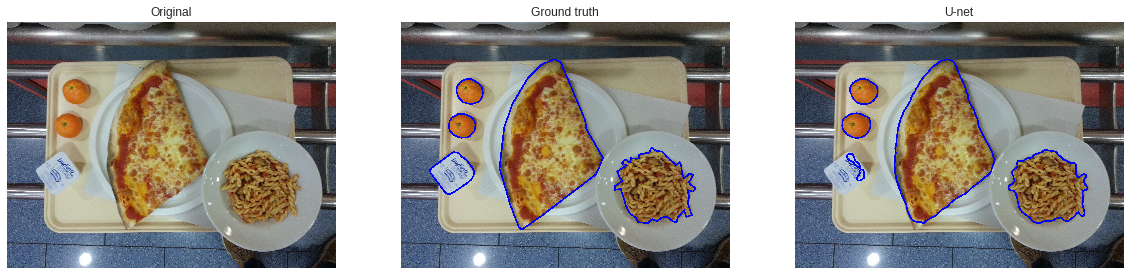

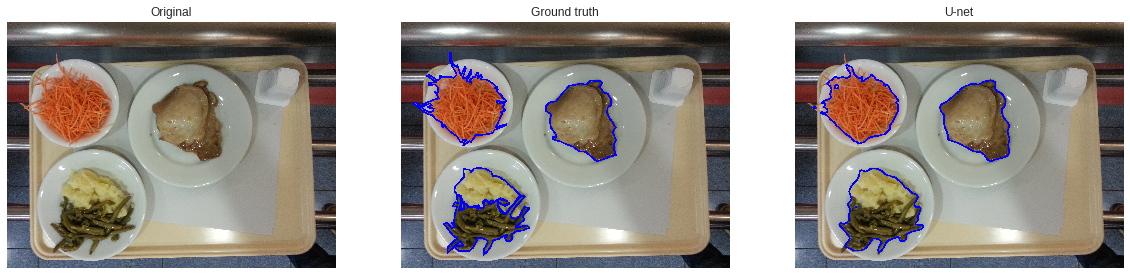

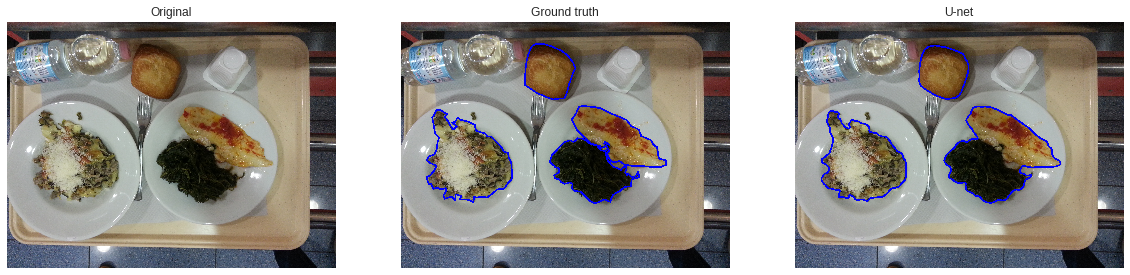

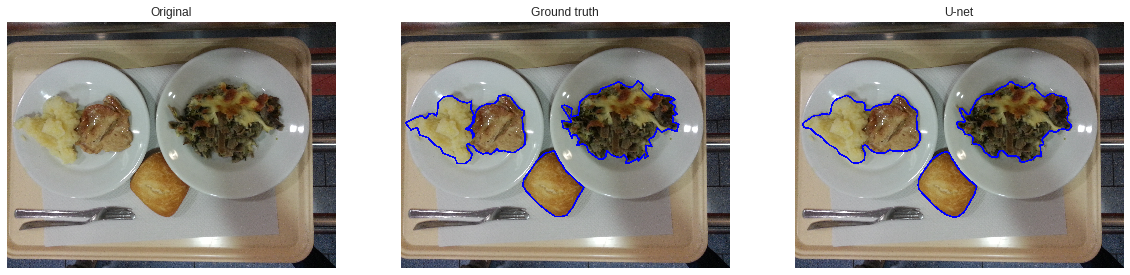

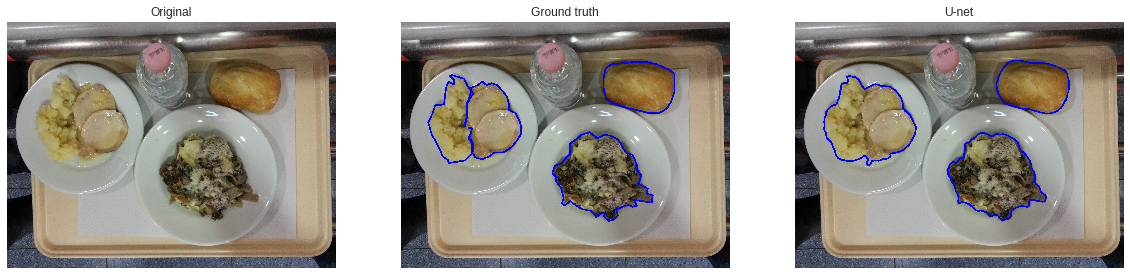

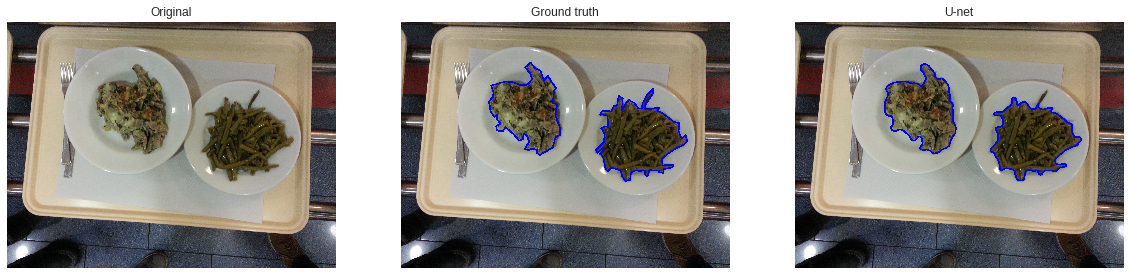

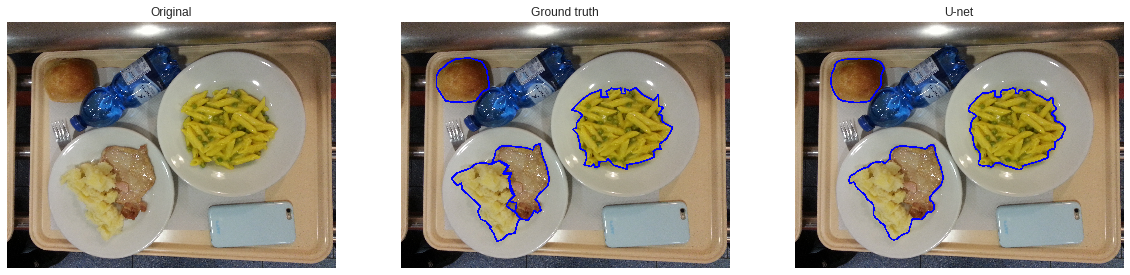

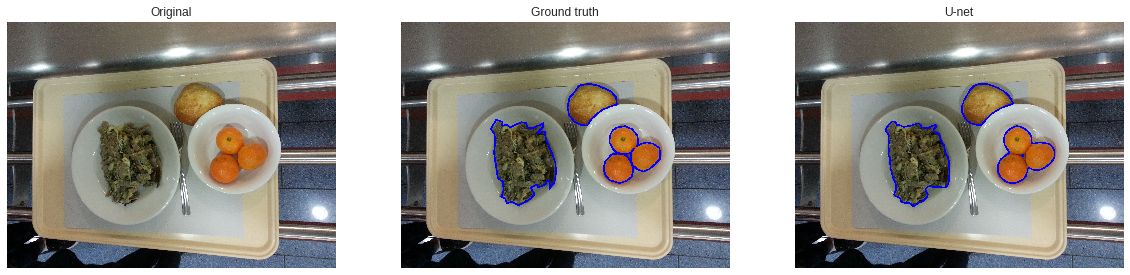

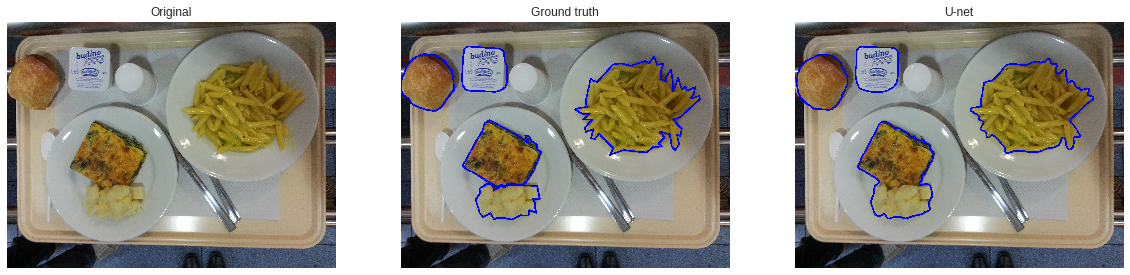

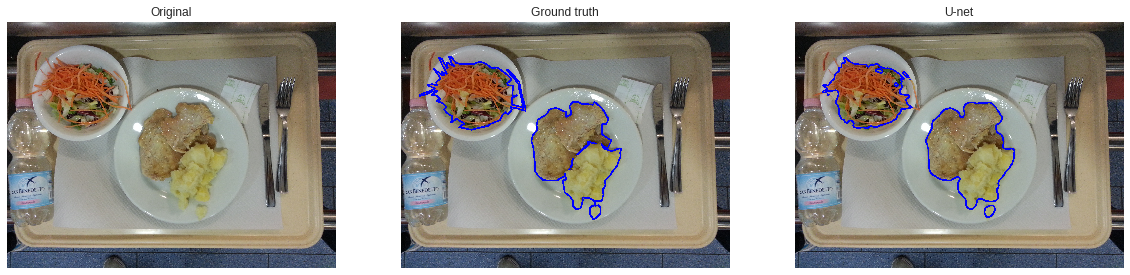

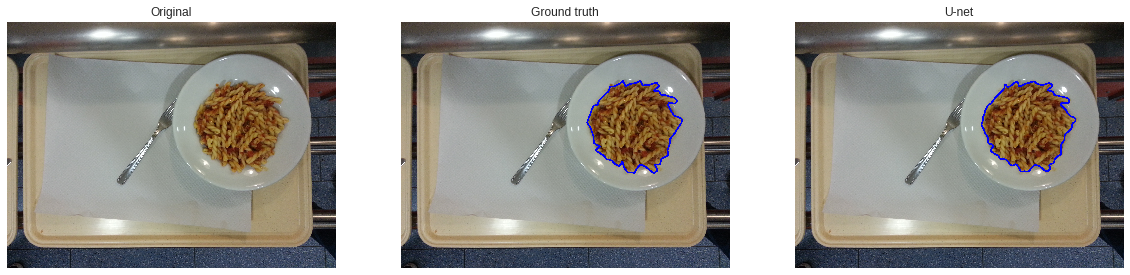

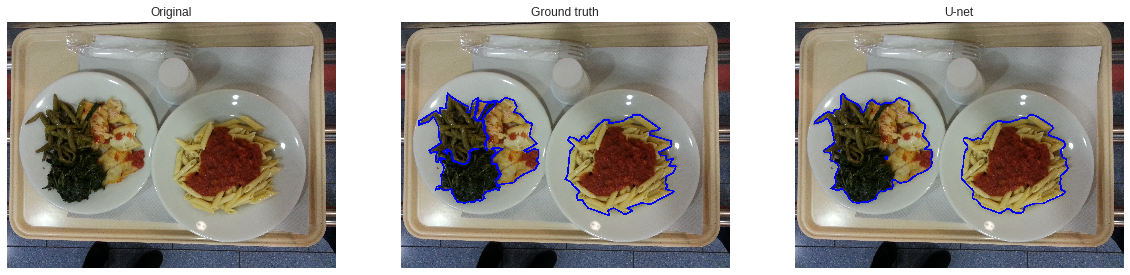

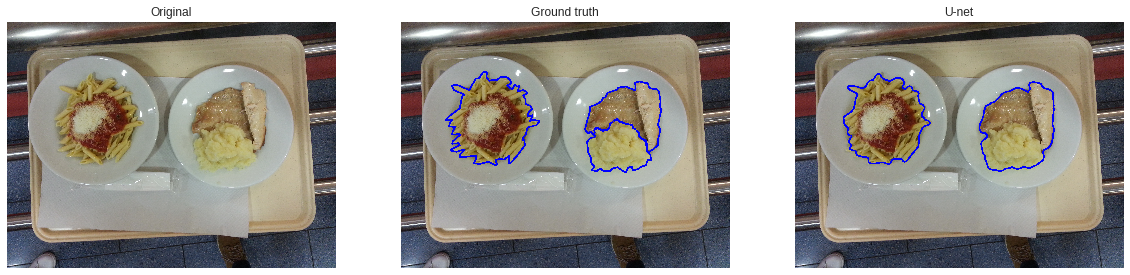

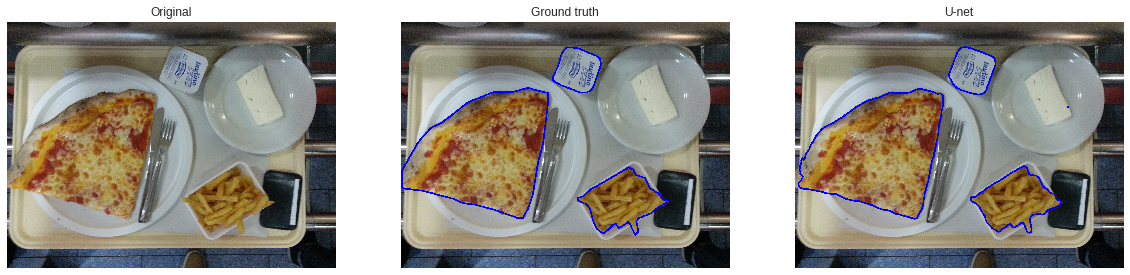

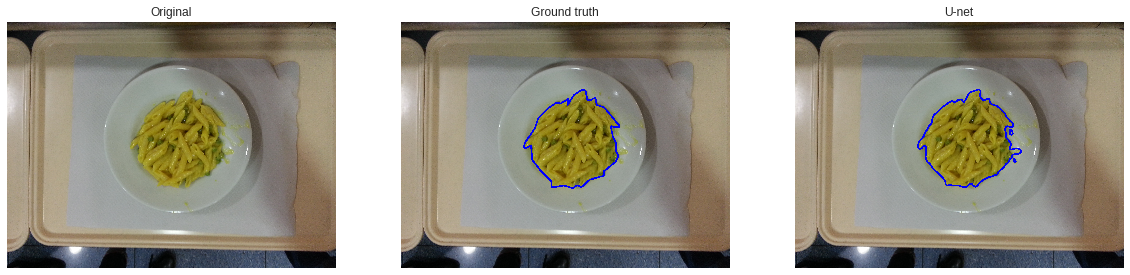

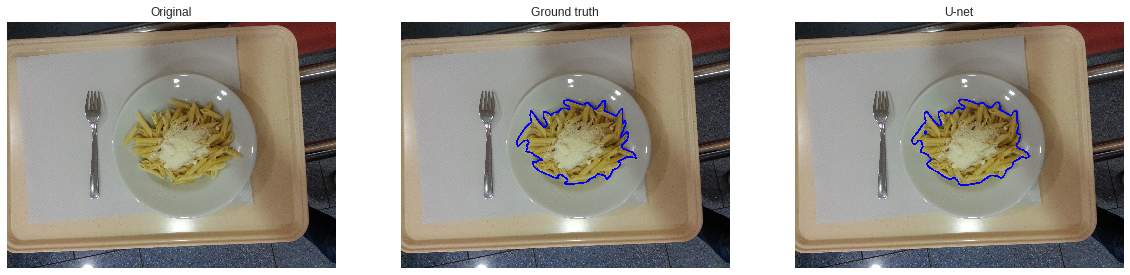

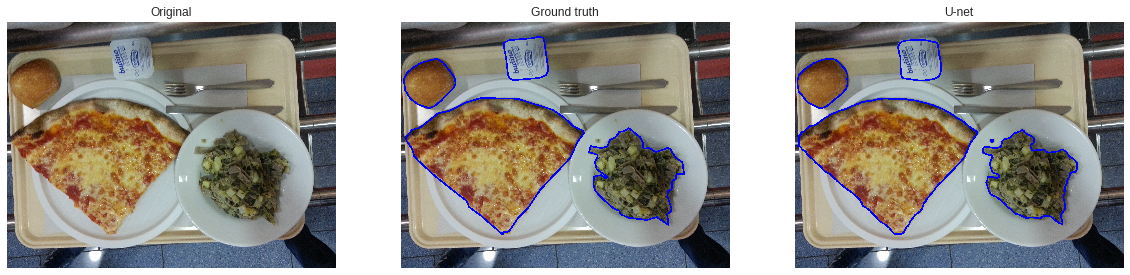

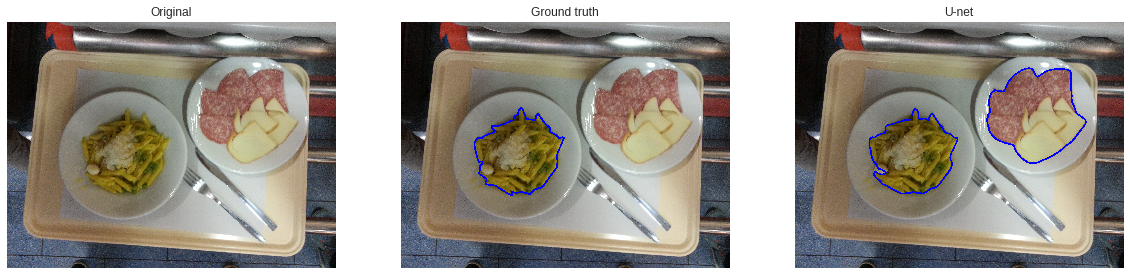

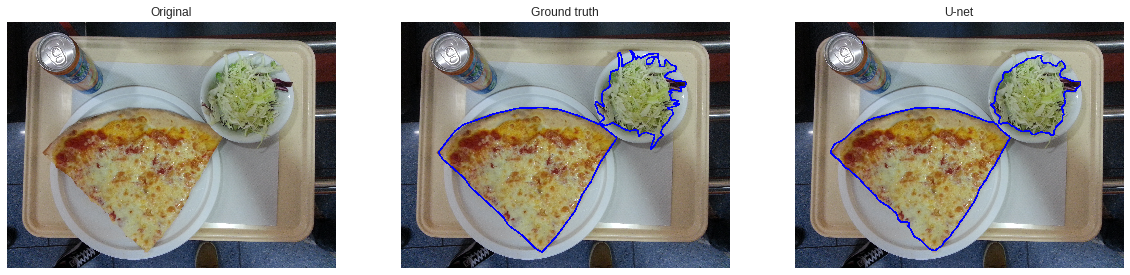

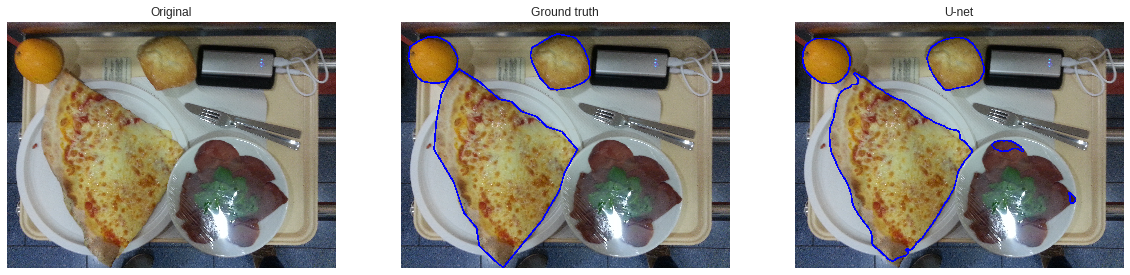

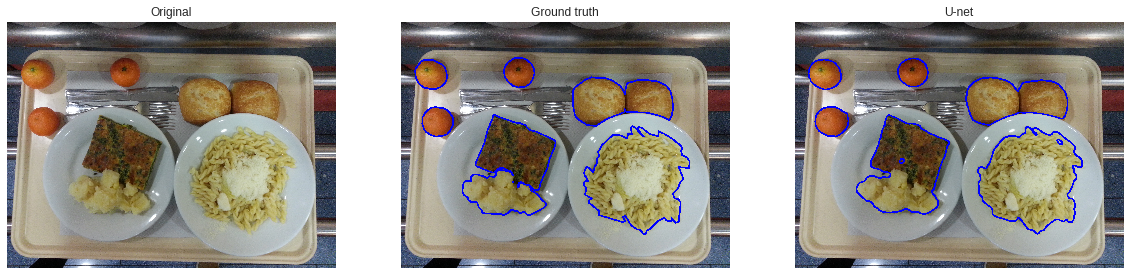

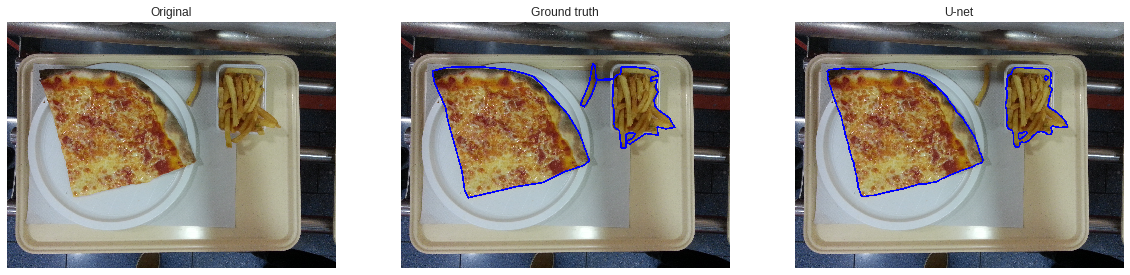

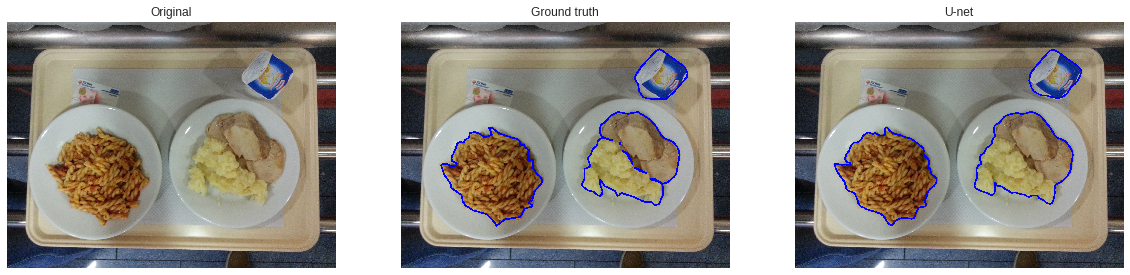

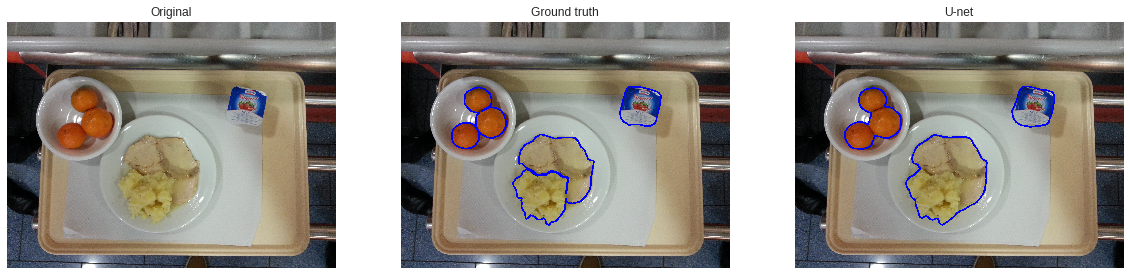

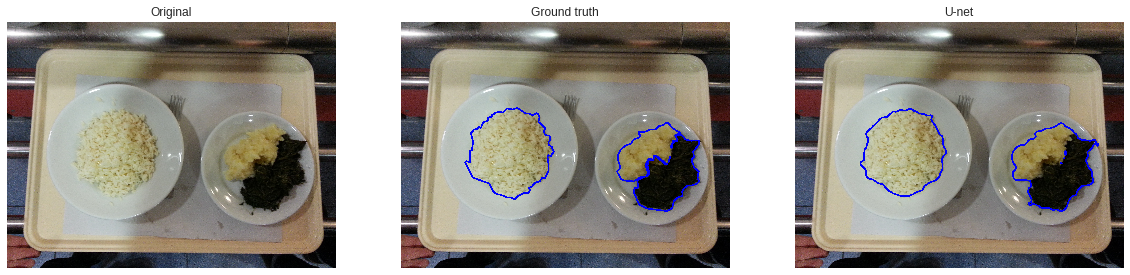

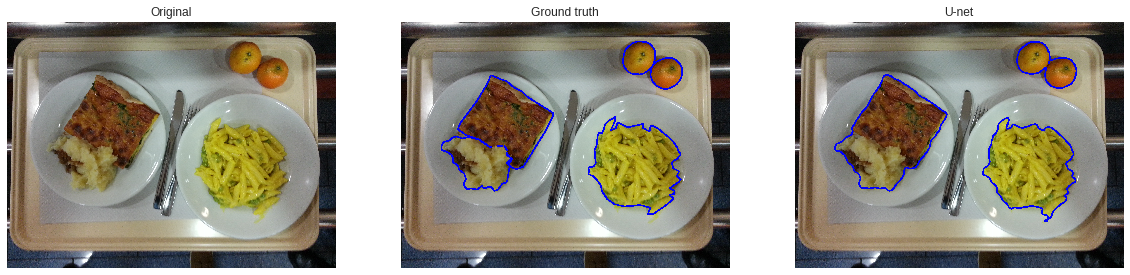

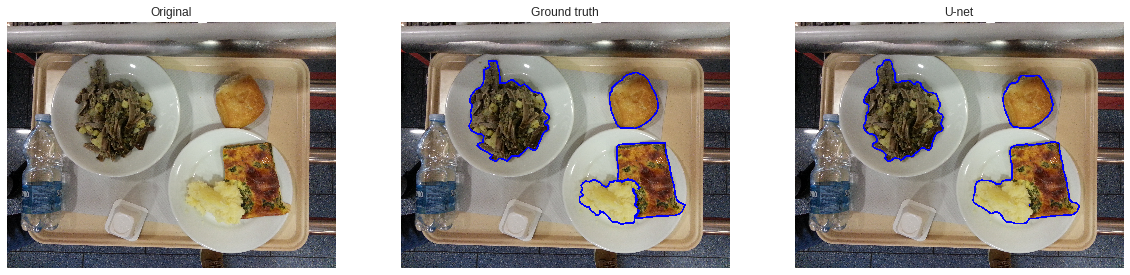

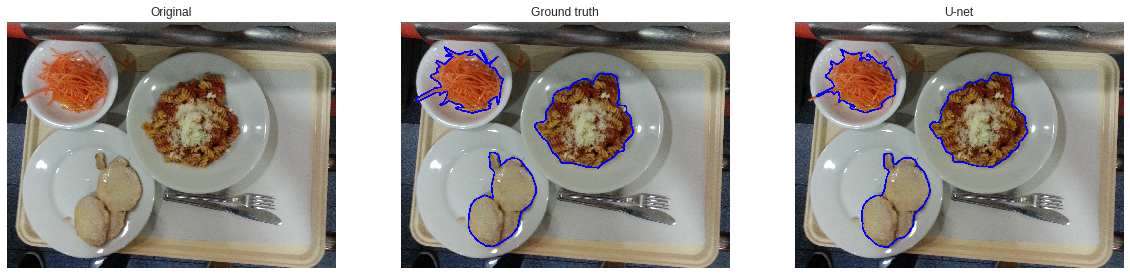

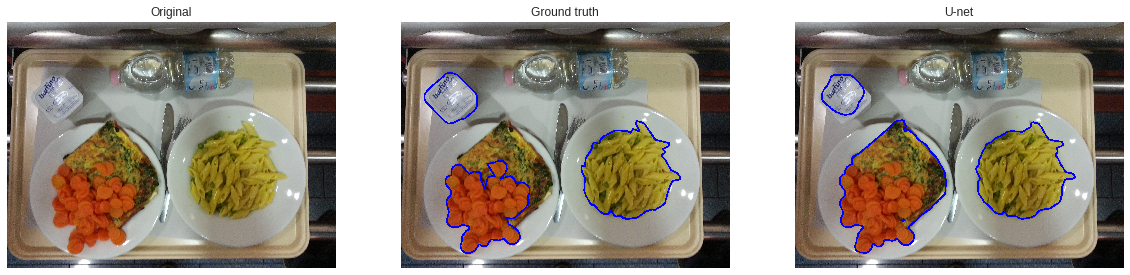

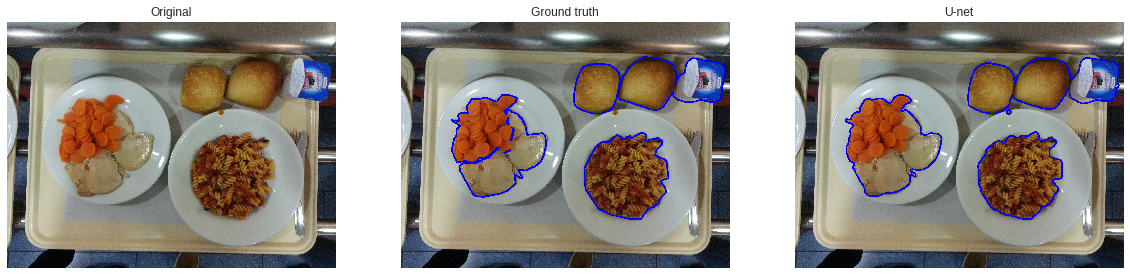

In [8]:
i = 30
for img_id in test_ids[:i]:
  plot_comparison_contours(img_id, 'adamax')